In [1]:
import os
from io import BytesIO

from typing import Optional, Union, Tuple, Dict, List
from random import randint

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.saving import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np

from PIL import Image
import cv2

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes

In [2]:
_PATH = '/Users/Aviad.Klein/Documents/learning/cv_class_for_kids/animals'
_MODEL_PATH = '/Users/Aviad.Klein/Documents/learning/cv_class_for_kids/models'

datasets = ['inf', 'train', 'val'] # there are 3 datasets that come with the Animals dataset
dataset_to_path = {k:f'{_PATH}/{k}' for k in datasets}

# these are the classes in the train and val datasets
# tensorflow uses the Generator classes and assigns a class based on the order of the directories
classes = ['cat', 'dog', 'horse', 'lion', 'elephant'] 

input_shape = (64, 64, 3)

In [3]:
def get_dataset_path(dataset: str='train') -> str:
    """returns the path of a specific dataset (train, val, inf) as str"""
    assert dataset in datasets, f"unknown dataset {dataset}, available options are: {datasets}"
    return f'{_PATH}/{dataset}'

def get_class_path(clazz: str, dataset: str='train') -> str:
    """returns the path of a specific class under a spcific dataset"""
    assert clazz in classes, f"unknown class {clazz}, available options are: {classes}"
    return f'{get_dataset_path(dataset)}/{clazz}'

def get_image_path(clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None) -> str:
    """will return a file of an image, if file is None, will choose a random image
    if file is an integer will return the image in the integer's index

    returns the path to the image
    """
    path = get_class_path(clazz, dataset)
    file_list = os.listdir(path) 
    size = len(file_list)
    if file is None:
        file = randint(0, size-1)
        return f'{path}/{file_list[file]}'
    elif isinstance(file, int):
        return f'{path}/{file_list[file]}'
    elif isinstance(file, str):
        assert file in file_list
        return f'{path}/{file}'
    else:
        raise ValueError()
    
def get_image_array(clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None, add_batch_axis: bool=False) -> Tuple[np.ndarray, str]:
    """returns a tuple of:
        image as an array of shape (x,x,3)
        path to the image
    if add_batch_axis is set to True will expand the shape to (batch,x,x,3)
    """
    path = get_image_path(clazz, dataset, file)
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = image.numpy()
    if add_batch_axis:
        image = np.expand_dims(image, axis=0)
    return image, path

def show_image(clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None, axis: bool=False):
    """plots an image from a specific class and dataset, can also specify file (see get_image_path)"""
    image_array, path = get_image_array(clazz, dataset, file)
    print(path)
    plt.imshow(image_array)
    if axis == False:
        plt.axis('off')
    plt.show()

def show_image_channels(clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None):
    """plots the image alongside it's rgb channels"""
    image_array, path = get_image_array(clazz, dataset, file)
    image_array[image_array < 0] = 0.
    image_array = image_array / image_array.max()
    print(path)
    fig = plt.figure(figsize=(7,7))
    ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8], pad=0.0)
    ax.imshow_rgb(image_array[:,:,0], image_array[:,:,1], image_array[:,:,2])

    plt.show()

def image_adjusted_for_model(target_size: Tuple[int, int], clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None) -> np.ndarray:
    img = image.load_img(get_image_path(clazz=clazz, dataset=dataset, file=file), target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255. 
    return img_array

def predict(model: Model, clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None) -> np.ndarray:
    img = image_adjusted_for_model(model.input_shape[1:3], clazz=clazz, dataset=dataset, file=file)
    y_hat = model.predict(img).reshape(-1)
    assert y_hat.size == len(classes)
    return y_hat

def plot_predict(model: Model, index2class: Dict[int, str], clazz: str, dataset: str='train', file: Optional[Union[str, int]]=None):
    """plots the image and next to it, a bar chart of the final activation layer"""
    image_array, path = get_image_array(clazz, dataset, file)
    filename = path.split('/')[-1]
    y_hat = predict(model, clazz, dataset, file)
    index = np.argmax(y_hat)
    clazz = index2class[index]
    _, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].imshow(image_array)
    ax[0].set_title(f'class={clazz[::-1]}, {filename=}')
    ax[1].bar(np.arange(5), height=(y_hat*100).astype(np.int16))
    ax[1].set_xticks([0,1,2,3,4])
    ax[1].set_xticklabels([index2class[i][::-1] for i in [0,1,2,3,4]])
    
    plt.show()

In [4]:
model = load_model(f'{_MODEL_PATH}/model_v1.keras')

In [5]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    get_dataset_path('val'),
    target_size=model.input_shape[1:3],  # Resize images to 64x64
    batch_size=32,
    class_mode='categorical')

Found 1497 images belonging to 5 classes.


In [6]:
index2class = {v: k for k, v in val_generator.class_indices.items()}
index2class_hebrew = {}

for k, v in index2class.items():
    match v:
        case 'cat':
            index2class_hebrew[k] = 'חתול'
        case 'dog':
            index2class_hebrew[k] = 'כלב'
        case 'horse':
            index2class_hebrew[k] = 'סוס'
        case 'lion':
            index2class_hebrew[k] = 'אריה'
        case 'elephant':
            index2class_hebrew[k] = 'פיל'

index2class_hebrew  

{0: 'חתול', 1: 'כלב', 2: 'פיל', 3: 'סוס', 4: 'אריה'}

1/1 [==============================] - 0s 79ms/step


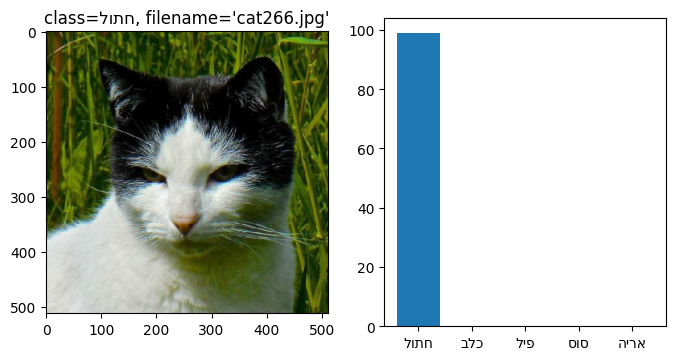

In [7]:
plot_predict(model, index2class_hebrew, dataset='val', clazz='cat', file='cat266.jpg')

In [8]:
# find weird cases
predictions = model.predict(val_generator)
kl_div = (predictions*np.log(predictions/(np.ones(5)/5))).sum(axis=1)
zipped = zip(kl_div, [_.split('/') for _ in val_generator.filenames])
zipped = sorted(zipped, key=lambda t: t[0])


47/47 [==============================] - 3s 53ms/step


In [9]:
zipped[:10]

[(0.2652970326260471, ['cat', 'cat18.jpg']),
 (0.3088387197214989, ['cat', 'cat89.jpg']),
 (0.3126862930754628, ['cat', 'cat149.jpg']),
 (0.3198751604226885, ['lion', 'lion256.jpg']),
 (0.39025814189451313, ['elephant', 'elephant46.jpg']),
 (0.4186601766607626, ['dog', 'dog154.jpg']),
 (0.42437293632573353, ['dog', 'dog20.jpg']),
 (0.43304481440515297, ['horse', 'horse216.png']),
 (0.4376737485824191, ['lion', 'lion151.jpg']),
 (0.44800860111667173, ['cat', 'cat300.jpg'])]

1/1 [==============================] - 0s 9ms/step


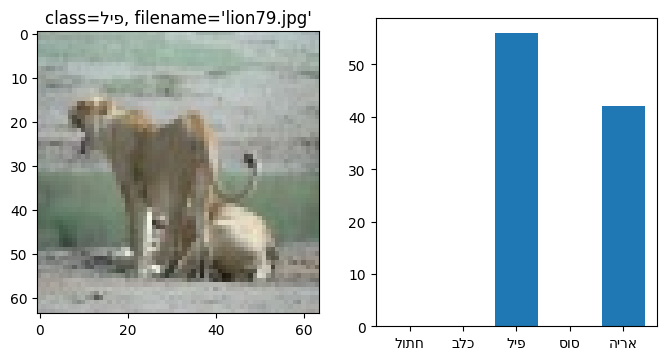

In [10]:
# plot_predict(model, index2class_hebrew, dataset='val', clazz='lion', file='lion173.jpg')
# plot_predict(model, index2class_hebrew, dataset='val', clazz='lion', file='lion83.jpg')
# plot_predict(model, index2class_hebrew, dataset='val', clazz='horse', file='horse44.png')
# plot_predict(model, index2class_hebrew, dataset='val', clazz='horse', file='horse236.png')
# plot_predict(model, index2class_hebrew, dataset='val', clazz='dog', file='dog42.png')
# plot_predict(model, index2class_hebrew, dataset='val', clazz='dog', file='dog81.jpg')
# plot_predict(model, index2class_hebrew, dataset='val', clazz='elephant', file='elephant183.jpg')
_ind = 20
plot_predict(model, index2class_hebrew, dataset='val', clazz=zipped[_ind][1][0], file=zipped[_ind][1][1])

In [11]:
mistakes = list(zip(np.argmax(predictions,axis=1), val_generator.labels, [_.split('/') for _ in val_generator.filenames]))
mistakes = list(filter(lambda t: t[0] == t[1], mistakes))
mistakes = list(map(lambda t: (t[-1][0], t[-1][1]), mistakes))


1/1 [==============================] - 0s 11ms/step


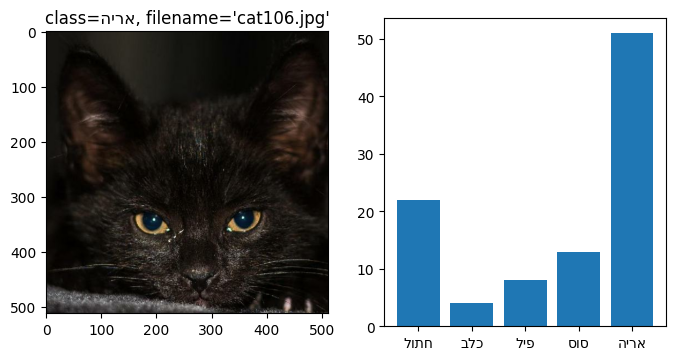

In [12]:
plot_predict(model, index2class_hebrew, dataset='val', clazz='cat', file='cat106.jpg')

1/1 [==============================] - 0s 9ms/step


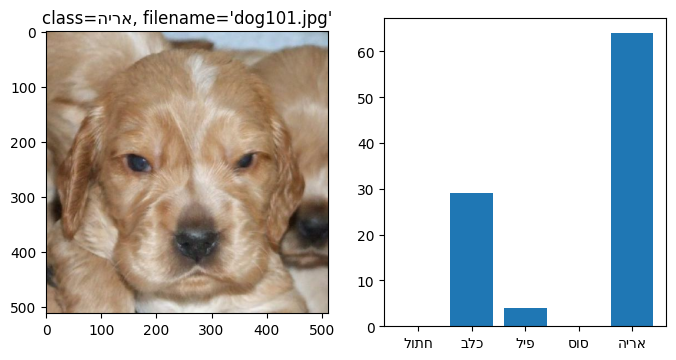

In [13]:
plot_predict(model, index2class_hebrew, dataset='val', clazz='dog', file='dog101.jpg')

1/1 [==============================] - 0s 9ms/step


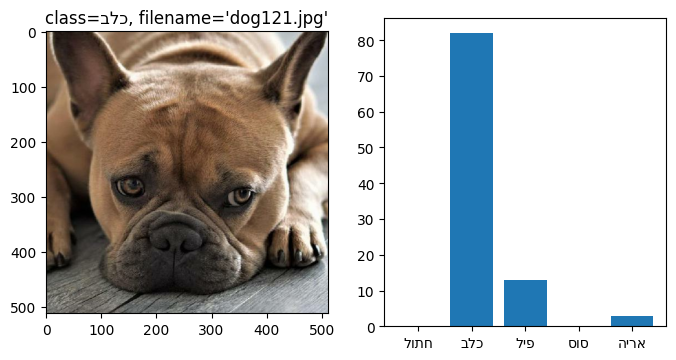

In [14]:
plot_predict(model, index2class_hebrew, dataset='val', clazz='dog', file='dog121.jpg')

In [15]:
layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

/Users/Aviad.Klein/Documents/learning/cv_class_for_kids/animals/train/dog/dog38.jpg


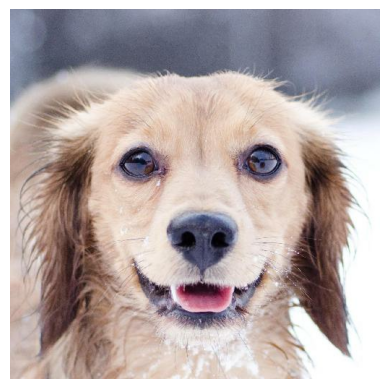

In [16]:
show_image('dog', file=45)

In [17]:
img = image.load_img(get_image_path('dog',file=45), target_size=input_shape[:2])
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255. 


In [18]:
activations = activation_model.predict(img_array)

1/1 [==============================] - 0s 26ms/step


In [19]:
for i, activation in enumerate(activations):
    print(f'{i}:{activation.shape[-1]}')   

0:32
1:64


In [20]:
def get_feature_array(activations, layer: int, feature: int):
    layer_activation = activations[layer]

    # The feature map has shape (1, size, size, n_features)
    height = layer_activation.shape[1]
    width = layer_activation.shape[2]

    grid = np.zeros((height, width ))

    feature_map = layer_activation[0, :, :, feature]
    feature_map -= feature_map.mean()
    _std = feature_map.std()
    if _std > 0:
        feature_map /= _std
    feature_map *= 64
    feature_map += 128
    feature_map = np.clip(feature_map, 0, 255).astype('uint8')

    return feature_map

def plot_feature_array(activations, layer: int, feature: int, scale: int = 3, cmap='viridis'):
    feature_map = get_feature_array(activations, layer, feature)
    plt.figure(figsize=(scale, scale))
    plt.imshow(feature_map, aspect='auto', cmap=cmap)
    plt.show()

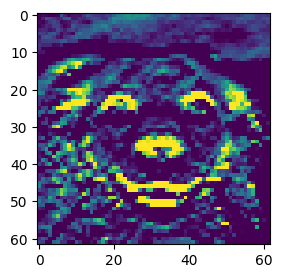

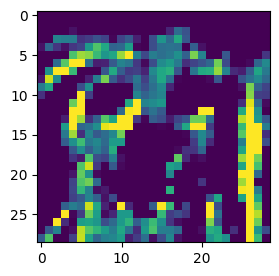

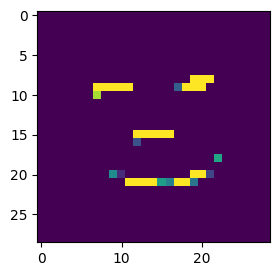

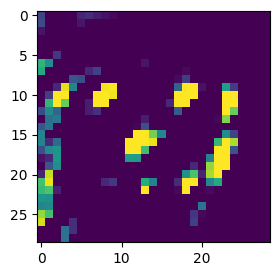

In [21]:
plot_feature_array(activations, 0, 1)
plot_feature_array(activations, 1, 4)
plot_feature_array(activations, 1, 25)
plot_feature_array(activations, 1, 45)

In [22]:
def live_feed(model, activation_model, layer_feature_tuples: List[Tuple[int, int]], scale: int=300):
    # Start capturing video from the webcam
    cap = cv2.VideoCapture(0)

    # Check if the webcam is opened correctly
    if not cap.isOpened():
        raise IOError("Cannot open webcam")
    
    while True:
        # Capture frame by frame
        ret, frame = cap.read()
        # Convert the frame to RGB
        # rgb_frame = cv2.cvtColor(frame, cv2.RGB)
        rgb_input = cv2.resize(frame, model.input_shape[1:3])
        rgb_input = np.expand_dims(rgb_input, axis=0) # Add batch axis
        
        pred = model.predict(rgb_input).reshape(-1)
        x = [0,1,2,3,4]
        fig, ax = plt.subplots(figsize=(4,4))
        ax.bar(x,pred)
        ax.set_xticks(x)
        ax.set_xticklabels([index2class_hebrew[i][::-1] for i in x])
        # Save the Matplotlib figure as an in-memory file
        figfile = BytesIO()
        plt.savefig(figfile, format='png')
        plt.close()
        figfile.seek(0)
        # Convert the in-memory file to an OpenCV image
        figdata = np.frombuffer(figfile.getvalue(), dtype=np.uint8)
        image = cv2.imdecode(figdata, 1)
        cv2.imshow("Classification", image)

        activations = activation_model.predict(rgb_input)

        cv2.imshow('Original', frame)
        for layer, feature in layer_feature_tuples:
            feature_array = get_feature_array(activations, layer, feature)
            resized_array = cv2.resize(feature_array, (scale, scale))
            cv2.imshow(f'activation({layer},{feature})', resized_array)

        # Press 'q' on the keyboard to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()



In [23]:
live_feed(model, activation_model, layer_feature_tuples=((0,1), (1,4), (1, 25), (1, 45)))

1/1 [==============================] - 0s 10ms/step
